In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import segmentation_models_pytorch as smp

/home/rmahajani31/anaconda3/envs/HubMapEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [18]:
DATA_DIR = './'
x_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset1_imgs')
y_train_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset1_masks')

x_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_imgs')
y_valid_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_masks')

x_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_imgs')
y_test_dir = os.path.join(DATA_DIR, 'full_training_data/all_dataset2_masks')

In [19]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [20]:
class HubMapDataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['unlabelled', 'blood_vessel']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

422


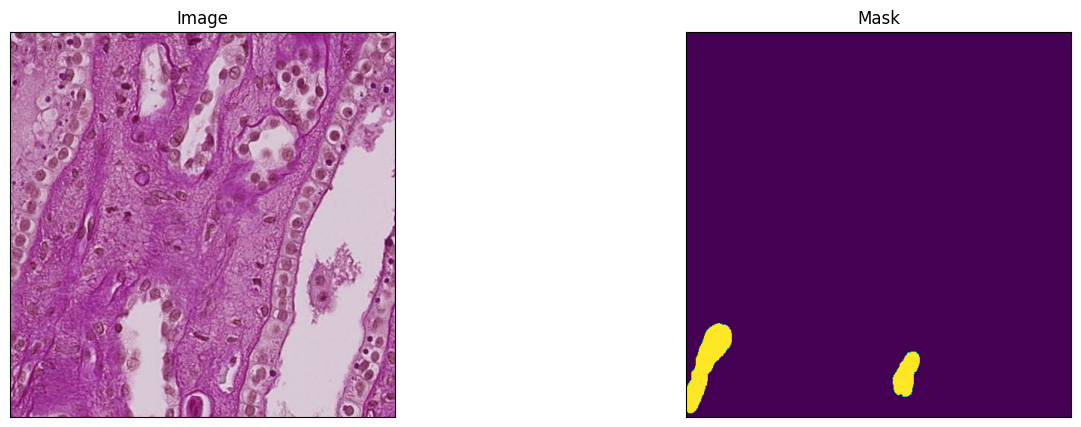

In [21]:
dataset = HubMapDataset(x_train_dir, y_train_dir, classes=['blood_vessel'])
print(len(dataset))
image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [22]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=352, always_apply=True, border_mode=0),
        albu.RandomCrop(height=512, width=352, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

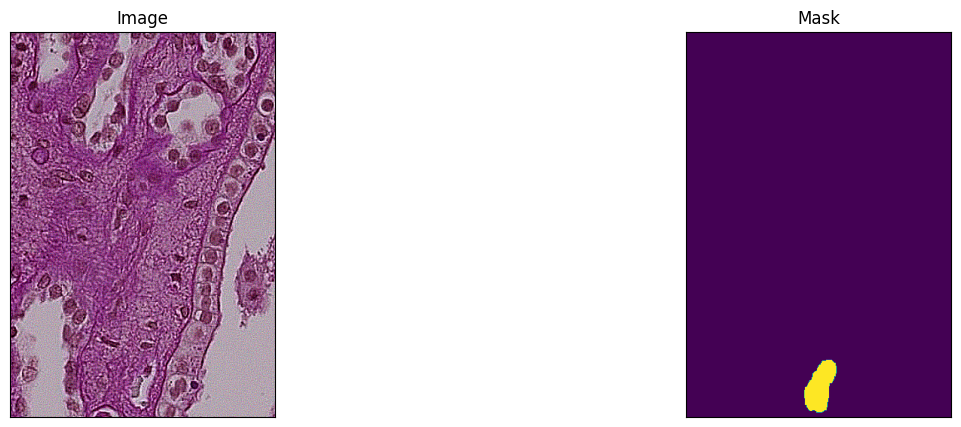

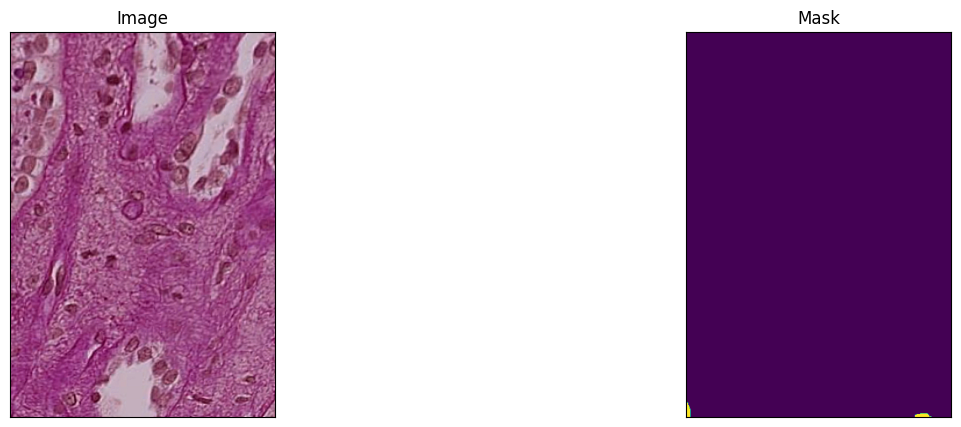

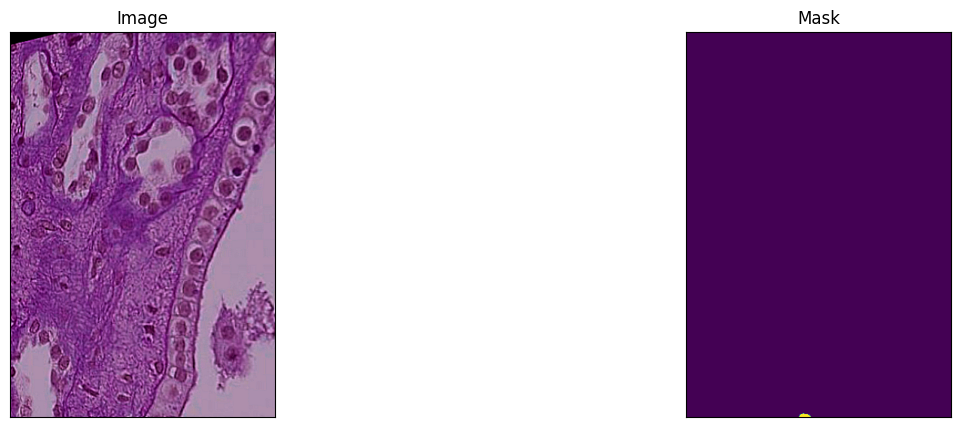

In [23]:
augmented_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['blood_vessel'],
)
# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[0]
    visualize(image=image, mask=mask.squeeze(-1))

In [9]:
CLASSES = ['unlabelled', 'blood_vessel']
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'

In [10]:
model = smp.Unet(
    encoder_name=ENCODER,        
    encoder_weights=ENCODER_WEIGHTS,     
    in_channels=3,                  
    classes=len(CLASSES)
)

In [11]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [12]:
train_dataset = HubMapDataset(
    x_train_dir, 
    y_train_dir,  
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = HubMapDataset(
    x_valid_dir, 
    y_valid_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
for i in range(5):
    image, mask = train_dataset[i]
    print(image.shape, mask.shape)
    visualize(image=image.transpose(1,2,0), mask=mask.squeeze())

In [ ]:
from torchmetrics import Metric
class IoUScore(Metric):
    def __init__(self, threshold=0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.threshold = threshold
        self.add_state("intersection", default=torch.tensor(0), dist_reduce_fx="sum")
        self.add_state("union", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, preds: torch.Tensor, target: torch.Tensor):
        print(f' Preds min: {torch.min(preds)}, Preds max: {torch.max(preds)}')
        preds = (preds > self.threshold).int()
        intersection = torch.logical_and(preds, target).sum()
        union = torch.logical_or(preds, target).sum()

        self.intersection += intersection
        self.union += union

    def compute(self):
        iou = self.intersection.float() / self.union.float()
        return iou

In [ ]:
loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
metrics = [
    IoUScore(threshold=0.5).to(DEVICE),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
from tqdm import tqdm
# Training loop
def train_epoch(model, loss_fn, metrics, optimizer, device, dataloader):
    model.train()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in training')
    # Iterate over the training dataset
    for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        print(f'Outputs min: {torch.min(outputs)}, Outputs max: {torch.max(outputs)}')
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Compute metrics
        for metric in metrics:
            metric.update(torch.sigmoid(outputs), targets)
        total_loss += loss

    # Get the metric values
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

# Validation loop
def valid_epoch(model, loss_fn, metrics, device, dataloader):
    model.eval()
    num_batches = len(dataloader)
    total_loss = 0
    print(f'Processing a total of {num_batches} batches in validation')
    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over the validation dataset
        for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            # Compute metrics
            for metric in metrics:
                metric.update(torch.sigmoid(outputs), targets)
            total_loss += loss

    # Get the metric values
    metric_values = [float(total_loss)/num_batches] + [metric.compute() for metric in metrics]
    return metric_values

In [ ]:
max_iou = 0
num_epochs = 50
if os.path.exists('./models/model_stats.txt'):
  os.remove('./models/model_stats.txt')
fp = open('./models/model_stats.txt', 'a')
for epoch in range(num_epochs):
    # Training
    train_metrics = train_epoch(model, loss, metrics, optimizer, DEVICE, train_loader)
    print(f'=========Finished Training Epoch {epoch}==========')
    # Validation
    valid_metrics = valid_epoch(model, loss, metrics, DEVICE, valid_loader)
    print(f'=========Finished Validation Epoch {epoch}=========')
    
    cur_validation_iou = valid_metrics[1]
    if cur_validation_iou > max_iou:
      print(f'Saving model with IoU: {cur_validation_iou}...')
      torch.save(model, './models/best_model.pth')
      with open('./models/best_model.txt', 'w') as f:
        f.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}")
      max_iou = cur_validation_iou
    # Print or log the metrics for each epoch
    print(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}")
    fp.write(f"Epoch {epoch}: Train Loss={train_metrics[0]}, Validation Loss={valid_metrics[0]}, Train IoU={train_metrics[1]}, Validation IoU={valid_metrics[1]}\n")
    fp.flush()
fp.close()

In [13]:
# Inference
from collections import OrderedDict
data_parallel_model = True
model_path = './models/unet-dataset1-batch-size-8-models/best_model_unet_dataset1.pth'
if data_parallel_model:
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    checkpoint_state = checkpoint.state_dict()
    modified_checkpoint_state = OrderedDict()
    for key, value in checkpoint_state.items():
      new_key = key[len('module.'):]
      modified_checkpoint_state[new_key] = value
    best_model = torch.load('./models/starter_model.pth', map_location=torch.device('cpu'))
    best_model.load_state_dict(modified_checkpoint_state)
    best_model = best_model.to(DEVICE)
else:
    best_model = torch.load(model_path, map_location=torch.device('cpu'))
    best_model = best_model.to(DEVICE)

In [24]:
CLASSES = ['unlabelled', 'blood_vessel']
test_dataset = HubMapDataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_loader = DataLoader(test_dataset)

In [ ]:
valid_metrics = valid_epoch(best_model, loss, metrics, DEVICE, test_loader)
print(f'Test Loss: {valid_metrics[0]}, Test IoU: {valid_metrics[1]}')

In [25]:
test_dataset_without_aug = HubMapDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)
train_dataset_without_aug = HubMapDataset(
    x_train_dir, y_train_dir, 
    classes=CLASSES,
)

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


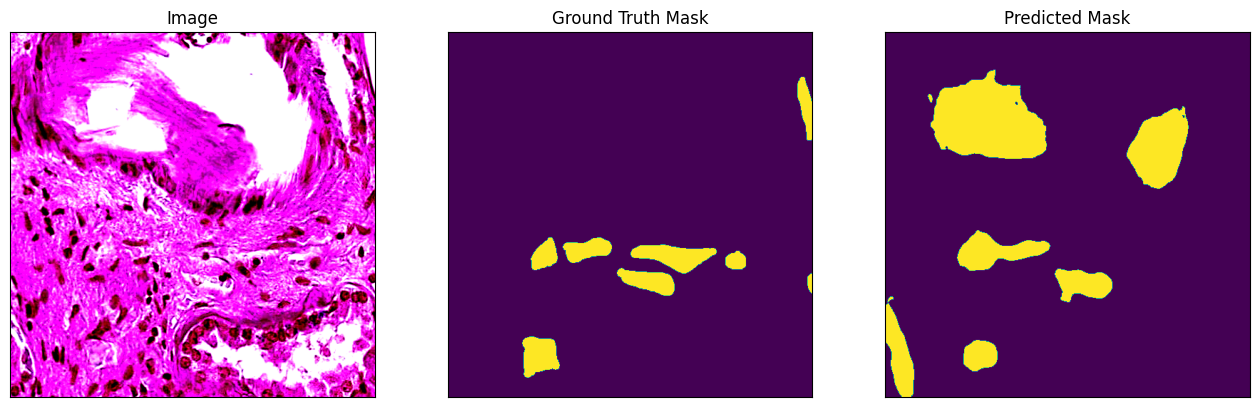

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


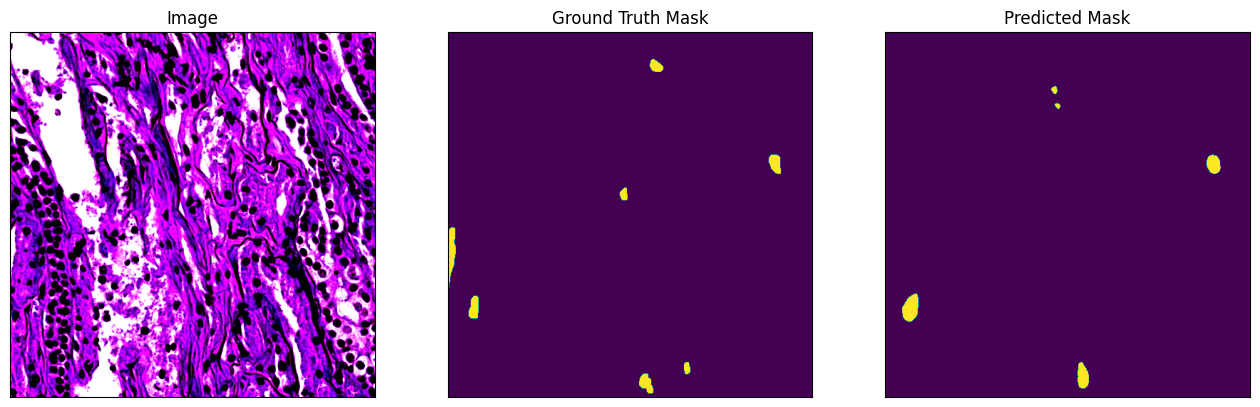

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


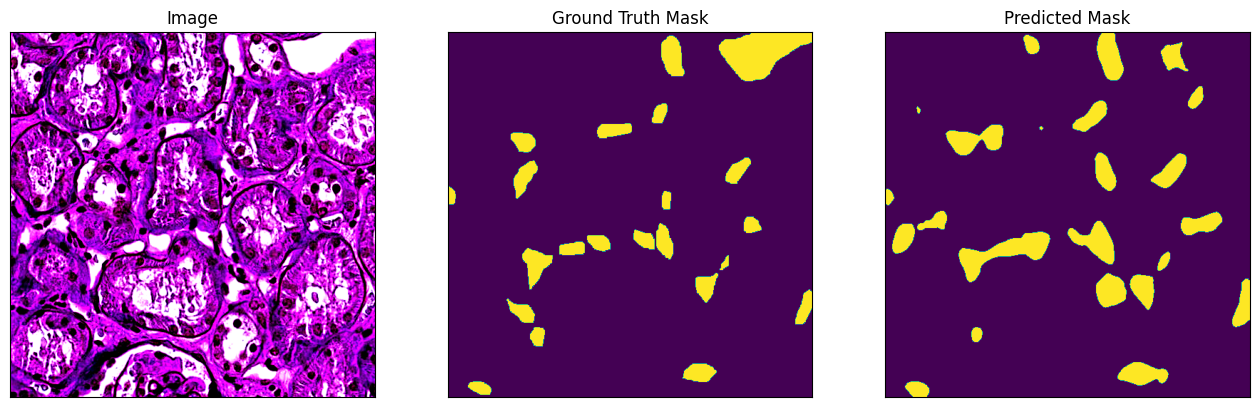

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


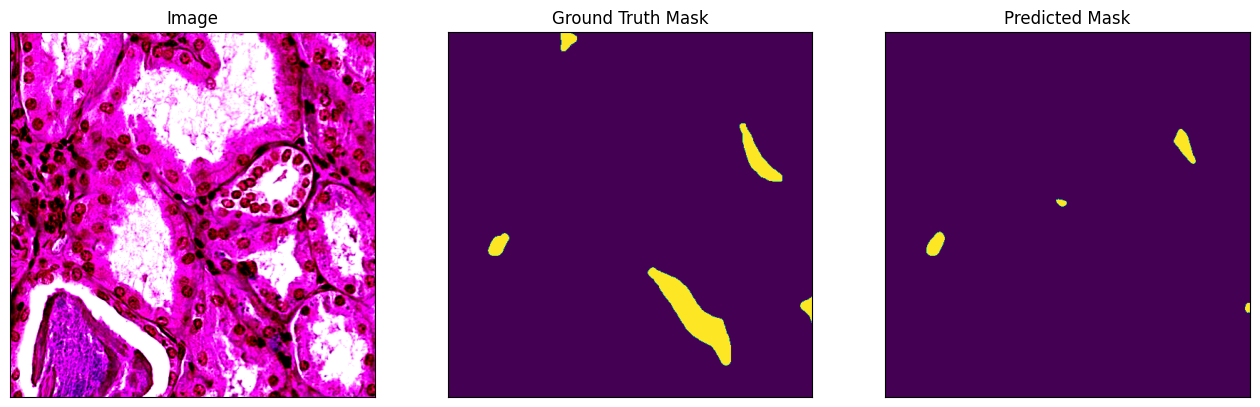

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


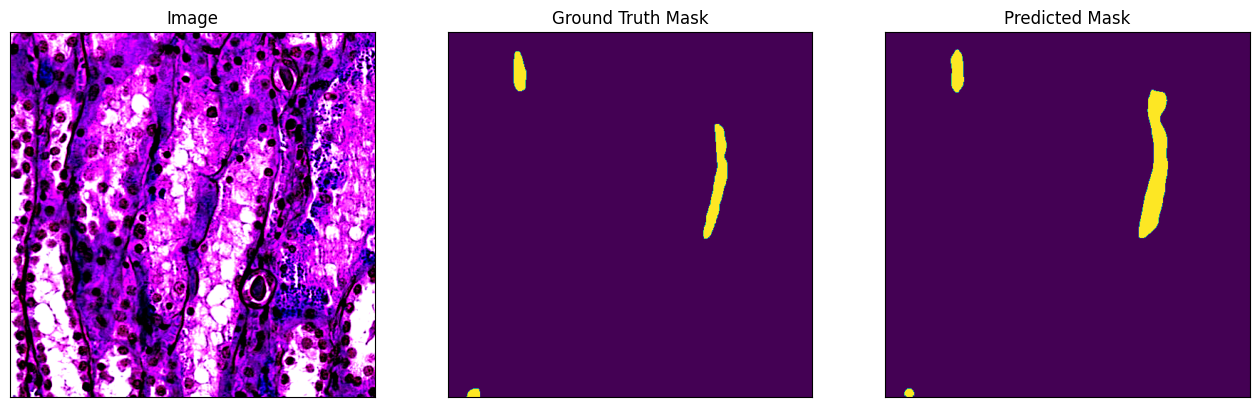

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


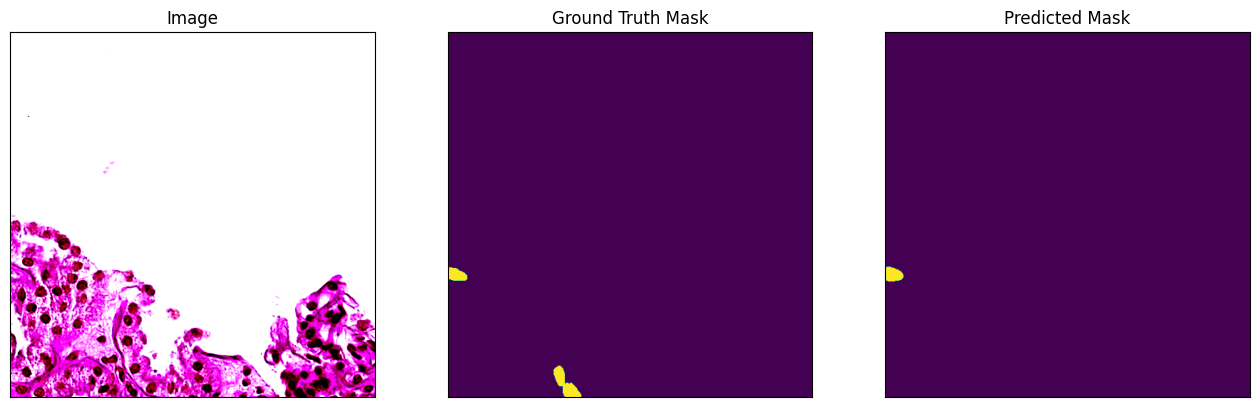

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


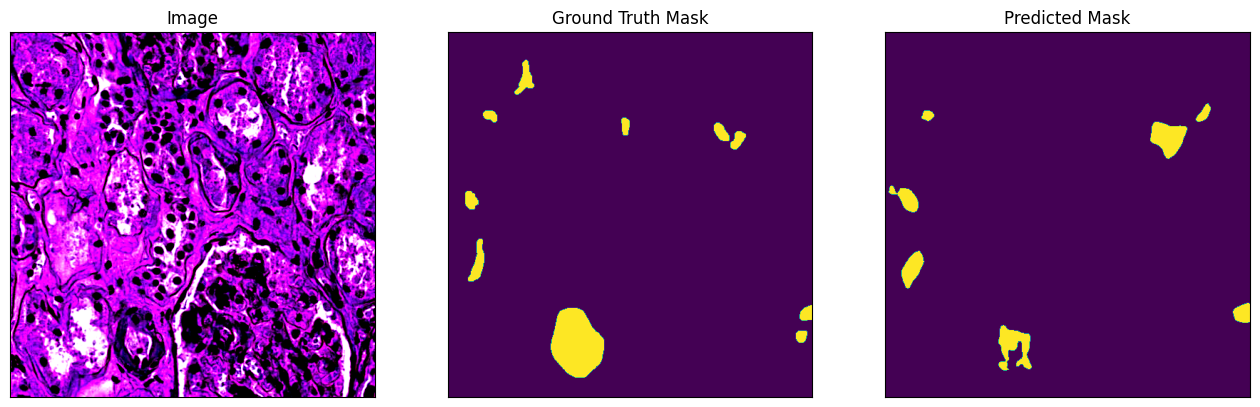

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


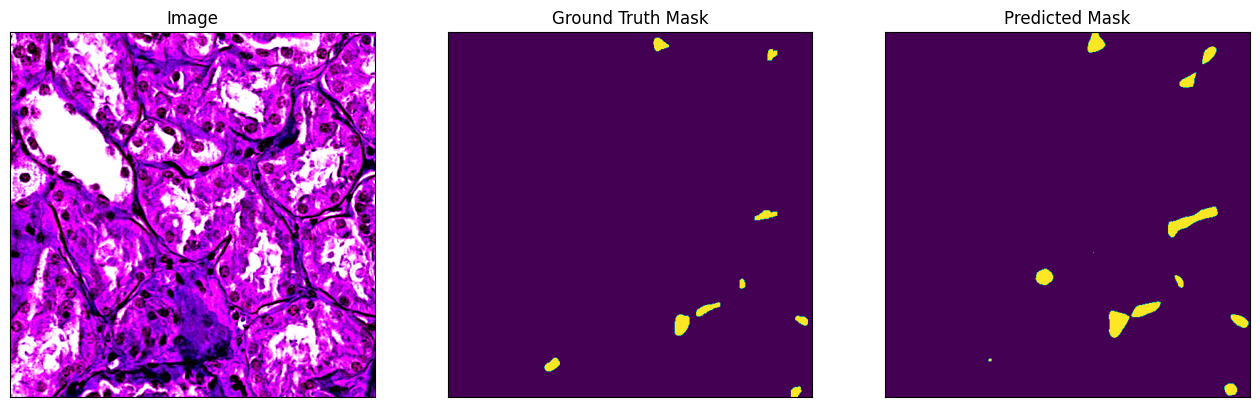

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


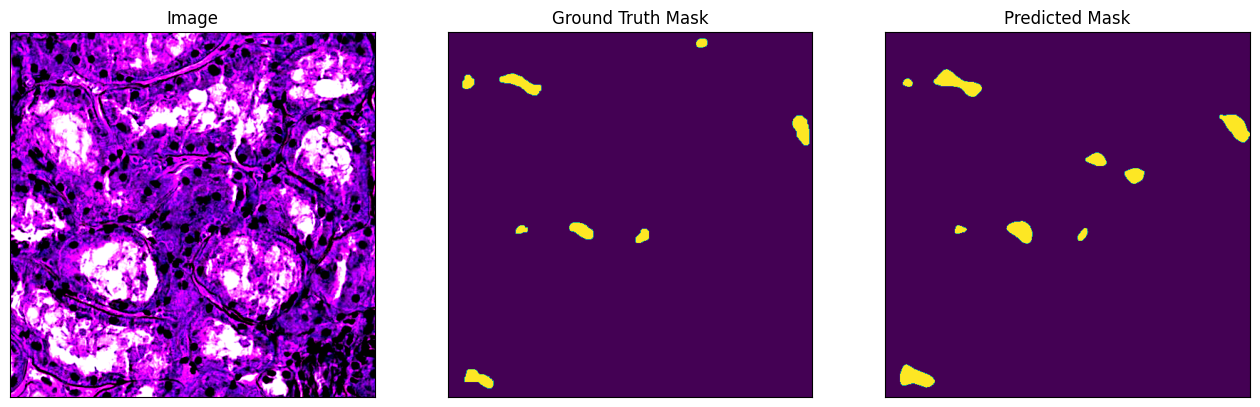

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


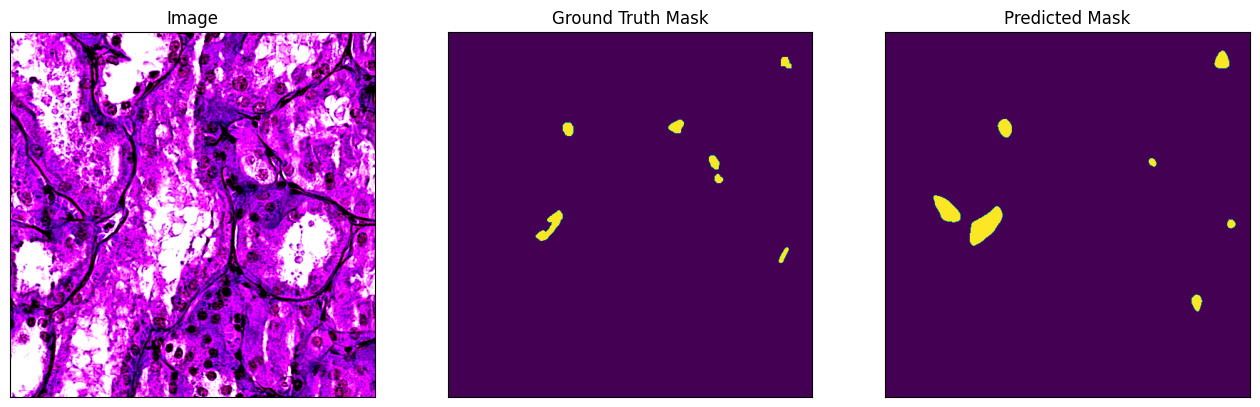

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


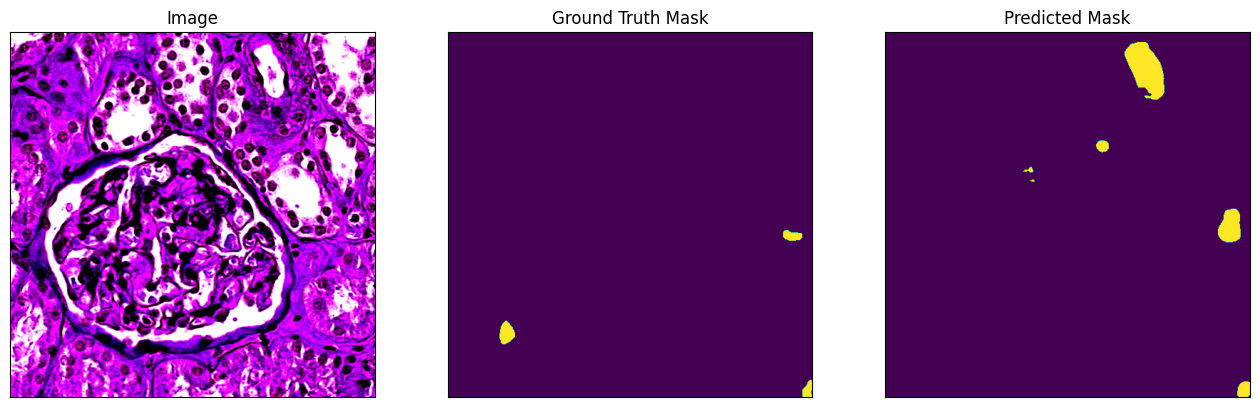

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


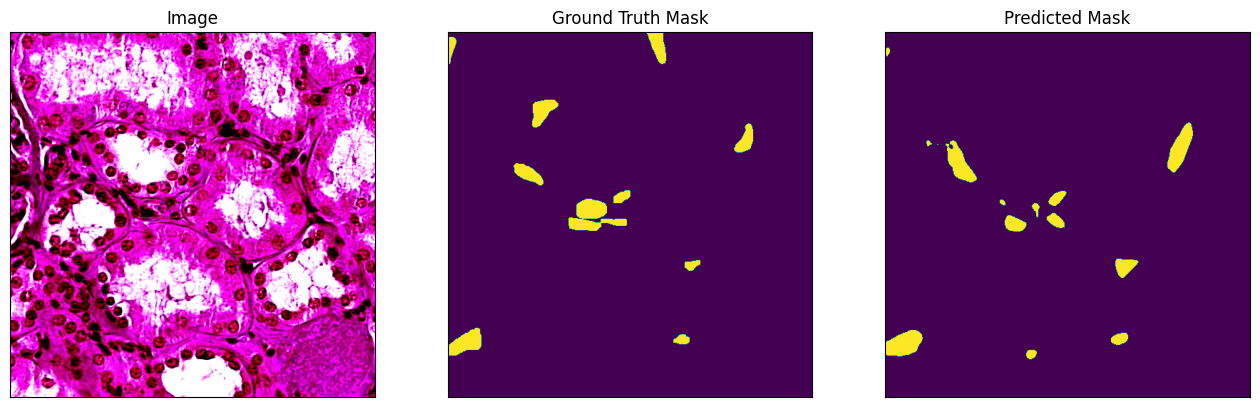

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


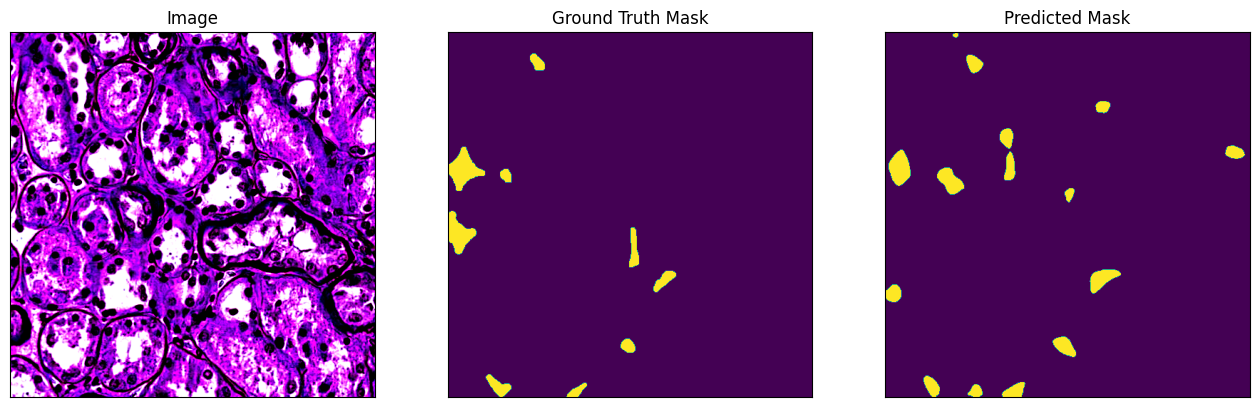

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


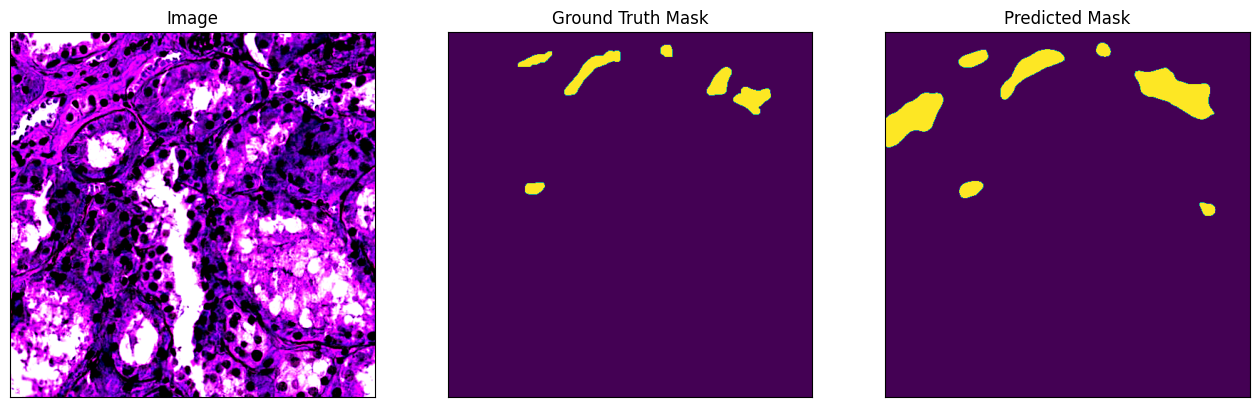

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


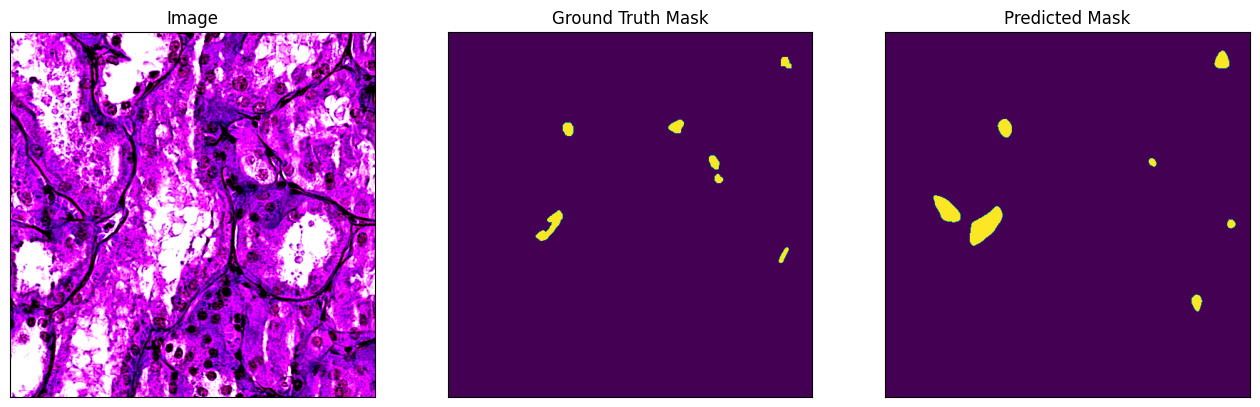

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


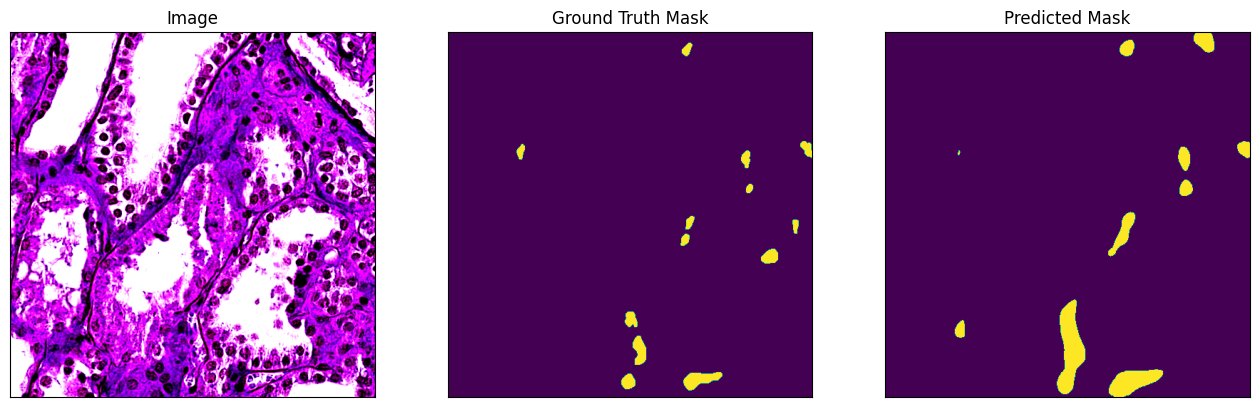

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


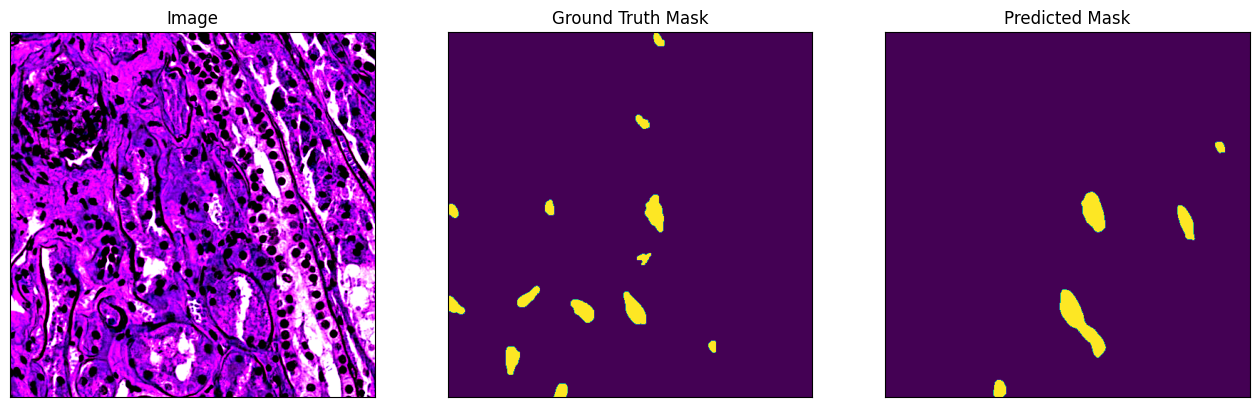

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


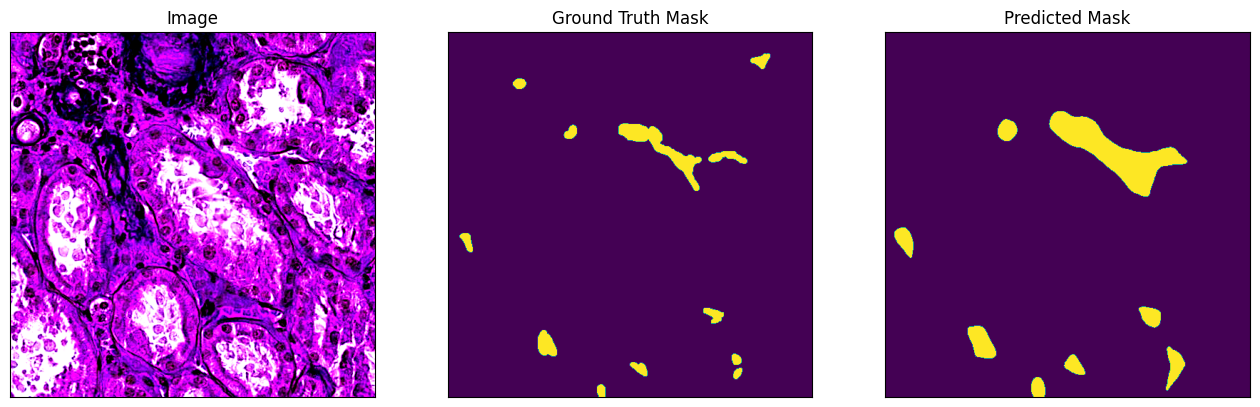

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


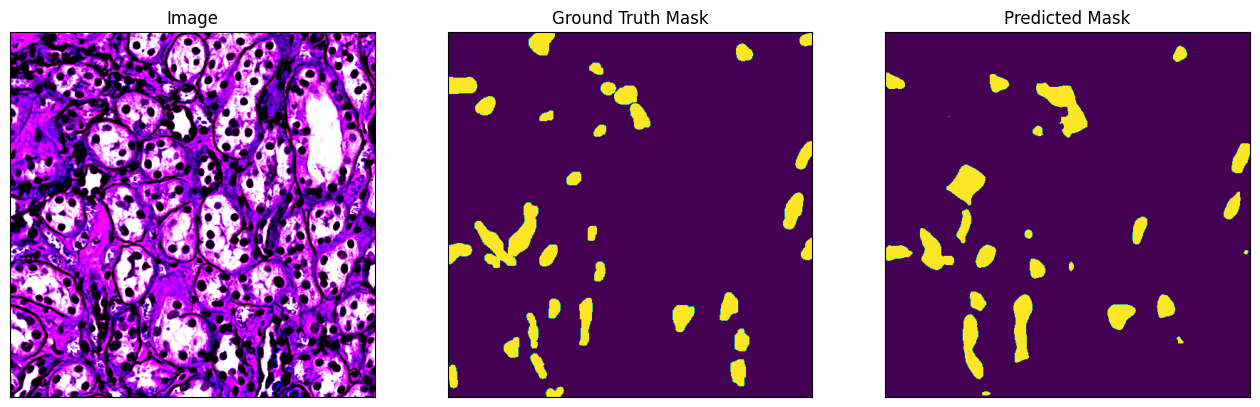

image tran shape: (512, 512, 3)
(3, 512, 512) (2, 512, 512)
torch.Size([1, 3, 512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2, 512, 512])
(2, 512, 512)


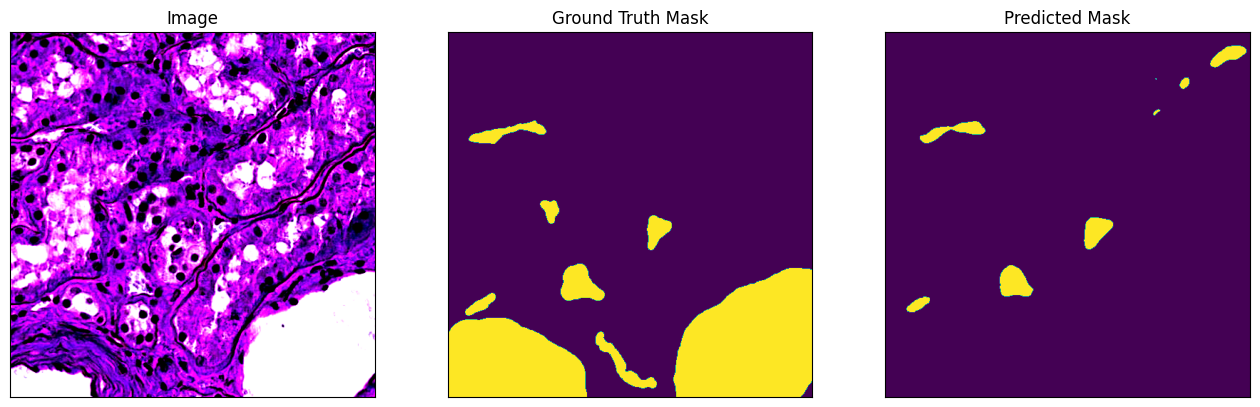

In [26]:
target_dataset = test_dataset
target_dataset_without_aug = test_dataset_without_aug
for i in range(20):
    n = np.random.choice(len(target_dataset))
    
    image_vis = target_dataset_without_aug[n][0].astype('uint8')
    image, gt_mask = target_dataset[n]
    image_trans = image.transpose(1,2,0)
    print(f'image tran shape: {image_trans.shape}')
    print(image.shape, gt_mask.shape)
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = torch.sigmoid(best_model.predict(x_tensor))
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    print(pr_mask.shape)
    
    visualize(
        image=image_trans, 
        ground_truth_mask=gt_mask[1,:,:], 
        predicted_mask=pr_mask[1,:,:]
    )

In [ ]:
visualize(
        image=image_trans, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

In [ ]:
print(pr_mask.shape)
print(pr_mask)
plt.imshow(pr_mask)
# im2, contours, hierarchy = cv2.findContours(pr_mask.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)